## Import lib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from collections import Counter, OrderedDict
from matplotlib import cm
from matplotlib import colors as col
from IPython import display
from IPython.display import HTML as html_print
from tqdm import trange, tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

## Upload dataset

In [2]:
path = "etsy_dataset.csv"
df = pd.read_csv(path, dtype=str).drop('Unnamed: 0', axis=1)
df = df.dropna().astype(str)
df.shape

(10000, 3)

In [3]:
df.head()

,id,category_id,description
0,691073911,69150433,1.47 ct Round shape Brilliant cut Black Color ...
1,691073895,69150433,This item contain one zip with the design in d...
2,691073889,69152975,VAPOR1995 Vintage Clothing!\n\nShipping is fro...
3,474004522,68933642,Personalised Black Wedding Socks with a No Col...
4,599059894,69151501,Gemstones Specification :\nSapphire:\nSapphire...


Max length of article: 12955


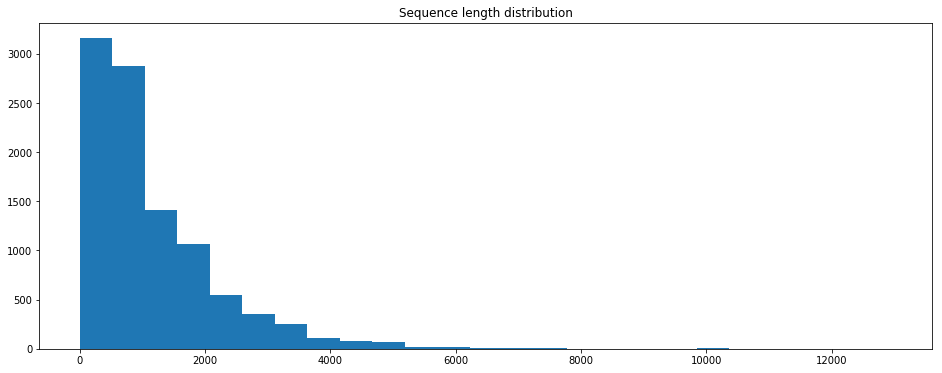

In [4]:
print("Max length of article:", df['description'].str.len().max())

plt.figure(figsize=(16,6))
plt.title('Sequence length distribution')
plt.hist(df['description'].str.len(), bins=25)
plt.show()

## Generate vocabulary

In [5]:
%%time
vocabulary, counts = np.unique(bytearray(''.join(df['description']).encode('unicode-escape')), return_counts=True)
n_letters = len(vocabulary)

print("Length of vocabulary:", len(vocabulary))
print("Vocabulary:", bytearray(vocabulary).decode('unicode-escape'), '\n')

Length of vocabulary: 91


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: invalid escape sequence '\]'
  """


Vocabulary:  !#$%&()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ 

Wall time: 369 ms


## OneHotEncode of the data and transform to the tensor

In [6]:
# article -> tensor

import torch

id2char = dict(enumerate(bytearray(vocabulary).decode('unicode-escape')))
char2id = {tok: i for (i, tok) in id2char.items()}

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(n_letters, dtype=torch.long)
    tensor[char2id.get(letter, 0)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line, lenght): 
    indeces = []
    for li, letter in enumerate(line):
        indeces += [[li + lenght - len(line), char2id.get(letter, 0)]]
    return torch.sparse_coo_tensor(np.array(indeces).T,
                                   torch.ones(len(indeces)),
                                   size=(lenght, n_letters)).to_dense()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: invalid escape sequence '\]'
  """


## DataLoader

In [7]:
#Change class name 
class DataLoader(Dataset):
    def __init__(self, texts, max_len=100):
        self.texts = texts
        self.max_len = max_len

    def __getitem__(self, idx):
        pos = np.random.randint(0, len(self.texts[idx]) - 1)
        x = self.texts[idx][pos: pos + self.max_len]
        
        y = torch.zeros(self.max_len - 1, dtype=torch.long)
        for k, ch in enumerate(x[1:]):
            y[k + self.max_len - 1 - len(x[1:])] = char2id.get(ch, 0)
        return lineToTensor(x[:-1], self.max_len - 1), y
    
    def __len__(self): 
        return (len(self.texts))

## Model architecture 

In [8]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.rnn = nn.RNN(vocab_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        out, hidden = self.rnn(input, hidden)
        out = self.decoder(out)
        return out.permute(0, 2, 1)
    
    def get_params(self):
        return (self.rnn._parameters['weight_ih_l0'],
                self.rnn._parameters['weight_hh_l0'],
                self.rnn._parameters['bias_ih_l0'],
                self.rnn._parameters['bias_hh_l0'])

## Initialize the model

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, n_letters).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.001)

cuda:0


In [10]:
BATCH_SIZE = 128
MAX_LEN = 1500

train_text, test_text = train_test_split(df[df['description'].str.len() > 10]['description'].values, test_size=0.2, shuffle=False)

trainset = DataLoader(train_text.copy(), MAX_LEN)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

testset = DataLoader(test_text.copy(), MAX_LEN)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

In [11]:
# if already trained:
PATH = 'models/RNN_HotEncode_29.pth'
rnn.load_state_dict(torch.load(PATH))
# and skip train

## Train

Train examples: 7999
Validation examples: 2000
Start training...
Epoch  0: Train loss 0.0128, Test loss: 0.0116, test accuracy = 0.73
Epoch  1: Train loss 0.0102, Test loss: 0.0088, test accuracy = 0.72
Epoch  2: Train loss 0.00833, Test loss: 0.00836, test accuracy = 0.73
Epoch  3: Train loss 0.00789, Test loss: 0.00774, test accuracy = 0.75
Epoch  4: Train loss 0.00793, Test loss: 0.00895, test accuracy = 0.72
Epoch  5: Train loss 0.00736, Test loss: 0.00728, test accuracy = 0.76
Epoch  6: Train loss  0.007, Test loss: 0.00687, test accuracy = 0.77
Epoch  7: Train loss 0.00683, Test loss: 0.00704, test accuracy = 0.76
Epoch  8: Train loss 0.00674, Test loss: 0.00676, test accuracy = 0.77
Epoch  9: Train loss 0.00654, Test loss: 0.00674, test accuracy = 0.77
Epoch 10: Train loss 0.00643, Test loss: 0.00638, test accuracy = 0.78
Epoch 11: Train loss 0.00627, Test loss: 0.00646, test accuracy = 0.78
Epoch 12: Train loss 0.00631, Test loss: 0.00621, test accuracy = 0.79
Epoch 13: Train l

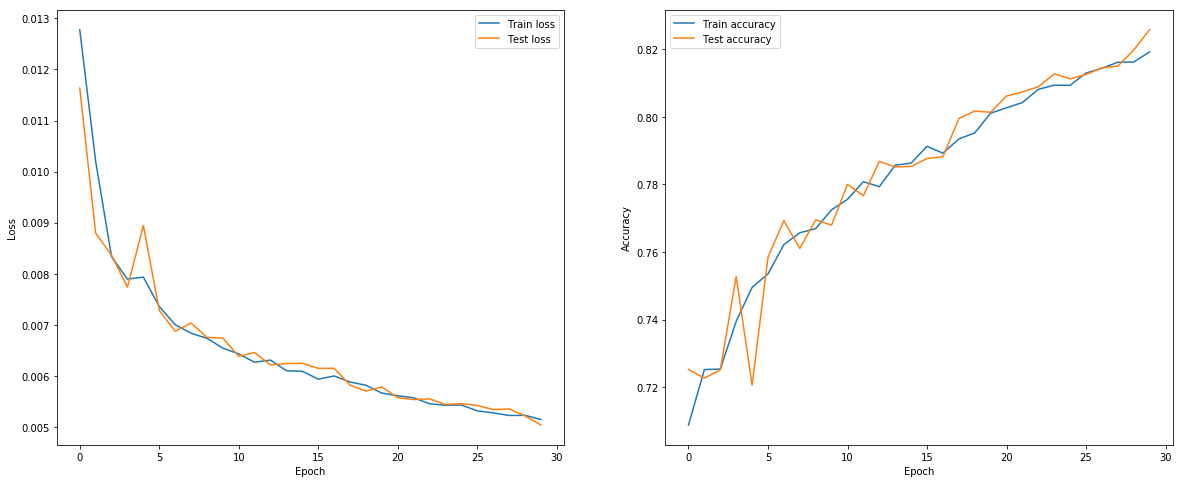

In [11]:
def train(model, optimizer, criterion, num_epochs=10, silent=False, model_name='RNN_HotEncode', path='models/'):
    print("Train examples: {}".format(len(trainset)))
    print("Validation examples: {}".format(len(testset)))
    print("Start training...")

    train_loss_plot = []
    test_loss_plot = []
    train_accur_plot = []
    test_accur_plot = []

    for epoch in range(num_epochs):
        if (not silent):
            print("Epoch {:2}: ".format(epoch), end='')
        else:
            print('.', end='')

        # train one epoch
        model.train()
        total_train_loss = 0
        correct_examples_train = 0
        for batch_idx, data in enumerate(trainloader):
            input, label = data
            if torch.cuda.is_available():
                input, label = input.cuda(), label.cuda()

            optimizer.zero_grad()
            
            hidden = torch.zeros((1, input.shape[0], n_hidden)).to(device)
            pred = model(input, hidden)  
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, pred_choice = F.softmax(pred, dim = 1).max(1)
            correct = pred_choice.eq(label).sum()
            correct_examples_train += correct.item()

        model.eval()
        correct_examples_test = 0
        total_test_loss = 0
        for batch_idx, data in enumerate(testloader):
            input, label = data
            if torch.cuda.is_available():
                input, label = input.cuda(), label.cuda()
            
            hidden = torch.zeros((1, input.shape[0], n_hidden)).to(device)
            pred = model(input, hidden)
            loss = criterion(pred, label)
            total_test_loss += loss.item()

            _, pred_choice = F.softmax(pred, dim = 1).max(1)
            correct = pred_choice.eq(label).sum()
            correct_examples_test += correct.item()

        torch.save(model.state_dict(), path + model_name + '_{}.pth'.format(epoch))
        
        if (not silent):
            print('Train loss {:6.3}, Test loss: {:6.3}, test accuracy = {:4.2f}'\
                  .format(total_train_loss / len(trainset), 
                          total_test_loss  / len(testset),
                          correct_examples_test / len(testset) / MAX_LEN))
        
        train_loss_plot.append(total_train_loss / len(trainset))
        test_loss_plot.append(total_test_loss  / len(testset))

        train_accur_plot.append(correct_examples_train / len(trainset) / MAX_LEN)
        test_accur_plot.append(correct_examples_test / len(testset) / MAX_LEN)

    plt.figure(figsize=(20, 8))
    plt.subplot(1,2,1)
    plt.plot(range(num_epochs), train_loss_plot)
    plt.plot(range(num_epochs), test_loss_plot)
    plt.legend(['Train loss', 'Test loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(range(num_epochs), train_accur_plot)
    plt.plot(range(num_epochs), test_accur_plot)
    plt.legend(['Train accuracy', 'Test accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

train(rnn, optimizer, criterion, num_epochs=30) # RMSprop (default params)

## Get activations

In [12]:
Wx, Wy, bx, by = rnn.get_params()
Wx.shape, Wy.shape, bx.shape, by.shape

(torch.Size([128, 91]),
 torch.Size([128, 128]),
 torch.Size([128]),
 torch.Size([128]))

In [13]:
def text2act(text):
    hidden = torch.zeros(n_hidden).to(device)
    output = np.empty((len(text), n_hidden))
    for i in range(len(text)):
        ch = text[i]
        hidden = torch.tanh(Wx.mv(letterToTensor(ch).float().to(device)) + bx + Wy.mv(hidden) + by)
        output[i] = hidden.cpu().detach().numpy()
    return output

In [14]:
# example text
idx = 50
print(test_text[idx])

Looking for different colors?  See all choices here:
http://etsy.me/1TKjjXr

The absolute best material for your piercing.  This one is a Implant Grade Titanium (Ti-6AL-4V-ELI ASTM F136) with a Highest Rated 5A Grade Cubic Zirconia.  

Grade 23 Titanium and any other grade Titanium do not come close to the quality and safety this material provides.  


- - - - - - - - - -


♥ Every Jewelry is crafted and shipped with our utmost care & love! ♥

We strive to bring you the best quality body jewelry for the best prices, along with many new captivating designs introduced regularly, so be sure to add our shop to your favorites.

If you should have any questions, please feel free to message us at anytime and we’ll get back to you as soon as possible. :)


- - - - - - - - - -


If you are looking to purchase more than 1 item in my shop, please be sure to add all items and check out all at once as you will be charged a single flat rate shipping fee, regardless of the number of items you may hav

In [15]:
output = text2act(test_text[idx])

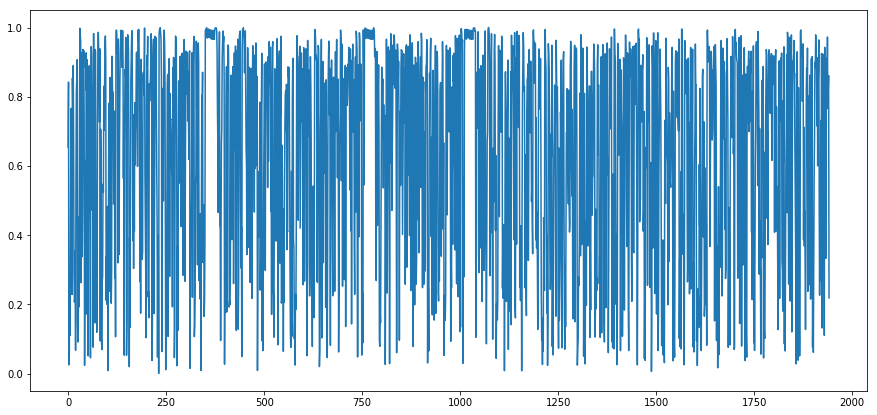

In [16]:
norm = col.Normalize()
plt.figure(figsize=(15, 7))
plt.plot(norm(output[:, 1]))
plt.show()

## Color patterns!

In [24]:
cmap = cm.get_cmap('brg_r')

def rgb_to_hex(rgb):
    rgb_int = tuple([int(255 * x) for x in rgb])
    return '%02x%02x%02x' % rgb_int


def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)


def text_pattern(text, activations, act_idx):
    text_colors = []
    for i in range(len(text)):
        text_colors.append(cstr(text[i], color='#' + rgb_to_hex(cmap(norm(activations[:, act_idx][i]))[:-1])))
    return html_print(cstr(''.join(text_colors), color='black') )

In [25]:
# websites
text = test_text[101]
activations = text2act(text)
text_pattern(text, activations, 8)

In [26]:
# first letters
text = test_text[41]
activations = text2act(text)
text_pattern(text, activations, 70)

In [27]:
# item size
text = test_text[28]
activations = text2act(text)
text_pattern(text, activations, 94)